In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras.models import load_model
from keras.utils import multi_gpu_model
import argparse
from matplotlib import pyplot as plt
from IPython.display import clear_output


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Using TensorFlow backend.


# The CIFAR-10 Dataset
![title](http://www.samyzaf.com/ML/cifar10/cifar1.jpg)

# Let's Scale it Down
CIFAR-10 is very heavy on your pc, so for now let's deal with 5 classes (instead of 10).

train
 (50000, 32, 32, 3) (50000, 1)
(25000, 32, 32, 3) (25000, 1)
test
 (10000, 32, 32, 3) (10000, 1)
(5000, 32, 32, 3) (5000, 1)


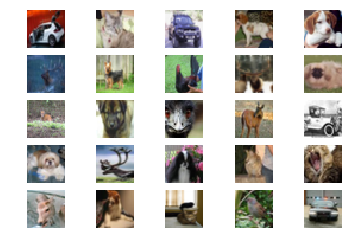

In [42]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

shrink_data = True
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if shrink_data:
    selected_classes = [1, 2, 3, 4, 5]
    print('train\n', x_train.shape, y_train.shape)
    x = [ex for ex, ey in zip(x_train, y_train) if ey in selected_classes]
    y = [ey for ex, ey in zip(x_train, y_train) if ey in selected_classes]
    x_train = np.stack(x)
    y_train = np.stack(y).reshape(-1,1)
    print(x_train.shape, y_train.shape)

    print('test\n', x_test.shape, y_test.shape)
    x = [ex for ex, ey in zip(x_test, y_test) if ey in selected_classes]
    y = [ey for ex, ey in zip(x_test, y_test) if ey in selected_classes]
    x_test = np.stack(x)
    y_test = np.stack(y).reshape(-1,1)
    print(x_test.shape, y_test.shape)
else:
    print('train\n', x_train.shape, y_train.shape)
    print('test\n', x_test.shape, y_test.shape)

# show some images
plt.figure(1)
for i in range (1,26):
    ax = plt.subplot(5,5,i)
    ax.axis('off')
    ax.imshow(x[i].reshape(32,32,3))
plt.show()

# CIFAR-10 Using DNN

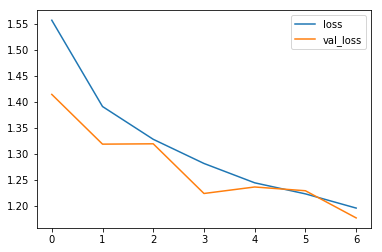

22500/22500 [==============================] - 11s 484us/step - loss: 1.1955 - acc: 0.5023 - val_loss: 1.1766 - val_acc: 0.5072
Epoch 8/100
14592/22500 [==================>...........] - ETA: 3s - loss: 1.1895 - acc: 0.4981

KeyboardInterrupt: 

In [43]:
batch_size = 256
num_classes = 10
epochs = 100

# paths for saving models
load_model = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_fc.h5'
model_path = os.path.join(save_dir, model_name)
model_checkpoint_call_back = keras.callbacks.ModelCheckpoint(model_path, 
                                                             monitor='val_loss', 
                                                             verbose=1, 
                                                             save_best_only=True, 
                                                             save_weights_only=False, 
                                                             mode='auto', 
                                                             period=1)


# The data, shuffled and split between train and test sets:
x_train = x_train.reshape(-1, 3072)
x_test = x_test.reshape(-1, 3072)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_fc = Sequential()
model_fc.add(Dense(512, activation='relu', input_shape=(3072,)))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(512, activation='relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(num_classes, activation='softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model_fc.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model_fc.fit(x_train, y_train,  # this is our training examples & labels
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,  # this parameter control the % of train data used for validation
          shuffle=True,
          callbacks=[plot_losses])  # this prints our loss at the end of every epoch

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_fc.save(model_path)
print('==> Saved trained model at %s ' % model_path)

# Score trained model.
scores = model_fc.evaluate(x_test, y_test, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])

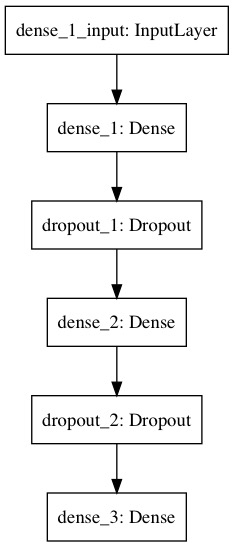

In [7]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

Image(model_to_dot(model_fc).create(prog='dot', format='jpg'))

OK, so we got a 55% accuracy, while this isn't the worst (10%), it's also not very good.

Lets try the model we have learned today.

# CIFAR-10 Using CNN

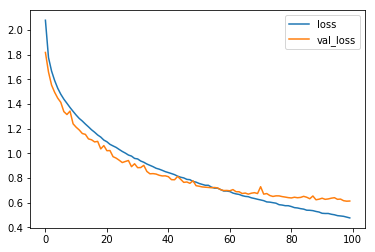

45000/45000 [==============================] - 4s 85us/step - loss: 0.4759 - acc: 0.8338 - val_loss: 0.6130 - val_acc: 0.8000
==> Saved trained model at /home/mlspeech/felixk/tmp/colman_ml/2017/lab_2/saved_models/keras_cifar10_trained_model_cnn.h5 
10000/10000 [==============================] - 1s 78us/step
==> Test loss: 0.647275308561
==> Test accuracy: 0.7775


In [4]:
batch_size = 256
num_classes = 10
epochs = 100

# paths for saving models
load_model = False
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_cnn.h5'
model_path = os.path.join(save_dir, model_name)
model_checkpoint_call_back = keras.callbacks.ModelCheckpoint(model_path, 
                                                             monitor='val_loss', 
                                                             verbose=1, 
                                                             save_best_only=True, 
                                                             save_weights_only=False, 
                                                             mode='auto', 
                                                             period=1)


# The data, shuffled and split between train and test sets:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if load_model and os.path.exists(model_path):
    print('==> loading pre-trained model')
    model = load_model(model_path)
else:
    print('==> creating a new model')
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train,  # this is our training examples & labels
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,  # this parameter control the % of train data used for validation
          shuffle=True,
          callbacks=[plot_losses])  # this prints our loss at the end of every epoch

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model.save(model_path)
print('==> Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])

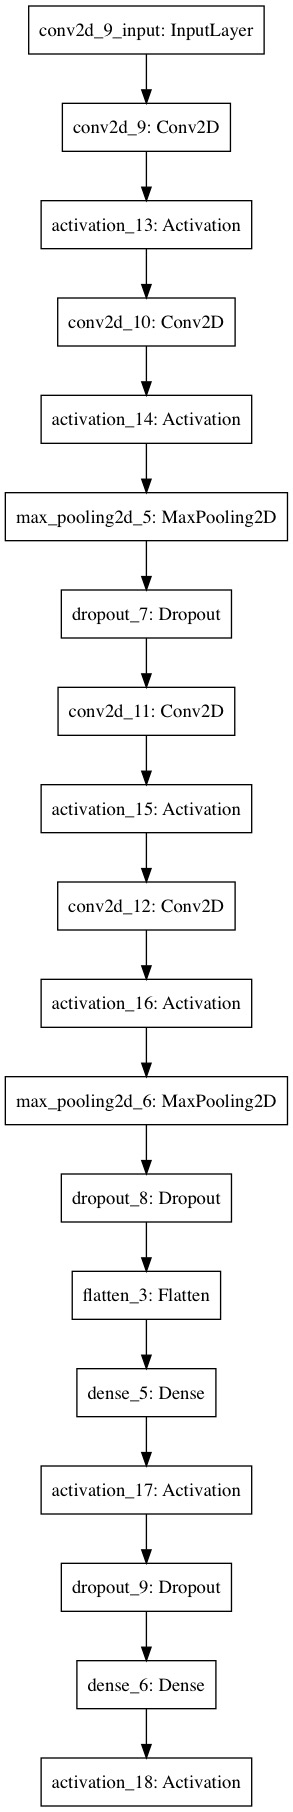

In [6]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

Image(model_to_dot(model).create(prog='dot', format='jpg'))

That's much better! we got an accuracy of 80% by just switching to convolutions.

# Prediction Example

(32, 32, 3)


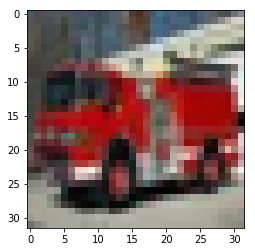

In [48]:
img = x_test[23]
label = np.argmax(y_test[23])
print(img.shape)
plt.imshow(img)

In [50]:
prediction = model.predict(img[np.newaxis,...])
prediction = np.argmax(prediction)
print('model prediction: {}'.format(prediction))
print('ground truth: {}'.format(label))
if prediction == label: print('great! we got it right')

model prediction: 9
ground truth: 9
great! we got it right


# OK, You Know The Deal
You should run 3 experiments, test different hyper-parameters such as: 
* learning rate
* dropout
* optimizers
* etc (see the full list in your first excercise).

Also,
* You can read more about Keras [here](https://keras.io).
* You can view many Keras code examples [here](https://github.com/fchollet/keras/tree/master/examples)
* You can view more Keras code examples at [www.google.com](www.google.com).